In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, AveragePooling2D, Lambda, Input, Dense, Flatten
from tensorflow.keras.layers import concatenate, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, PReLU, Activation, Lambda
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

## Test 01

In [ ]:
optimizer = SGD(learning_rate=1e-2, momentum=9e-1)
weight_decay = 5e-4


# vgg with leaky relu
def vgg_net16_lr(input_shape=(224, 224, 3), classes=None, alpha=0.3):
    # input layer
    input_layer = Input(shape=input_shape, name='input_')

    # first conv block
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(
        input_layer)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # second conv block
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # third conv block
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # fourth conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # fifth conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), kernel_regularizer=l2(weight_decay), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

    # classifier
    x = Flatten()(x)
    x = Dense(units=512)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=512)(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=classes, activation='softmax')(x)

    model = Model(input_layer, x)
    model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
    # model.summary()

    return model

In [ ]:
# inception with leaky relu
def inception(x, filters, projection, classes=None, aux=False, name=None, aux_name=None, alpha=0.3):
    f_1x1, f_3x3, f_3x3_reduce, f_5x5, f_5x5_reduce = filters
    x1 = Conv2D(filters=f_1x1, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x1 = LeakyReLU(alpha=alpha)(x1)
    x3_reducer = Conv2D(filters=f_3x3_reduce, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x3_reducer = LeakyReLU(alpha=alpha)(x3_reducer)
    x5_reducer = Conv2D(filters=f_5x5_reduce, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x5_reducer = LeakyReLU(alpha=alpha)(x5_reducer)
    pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    x3 = Conv2D(filters=f_3x3, kernel_size=(3, 3), strides=(1, 1), padding='same')(x3_reducer)
    x3 = LeakyReLU(alpha=alpha)(x3)
    x5 = Conv2D(filters=f_5x5, kernel_size=(5, 5), strides=(1, 1), padding='same')(x5_reducer)
    x5 = LeakyReLU(alpha=alpha)(x5)
    proj = Conv2D(filters=projection, kernel_size=(1, 1), strides=(1, 1), padding='same')(pool)
    proj = LeakyReLU(alpha=alpha)(proj)

    x = concatenate([x1, x3, x5, proj], axis=3, name=name)

    return x


def model_builder(shape, classes, alpha=0.3):
    input_layer = Input(shape=shape)
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU(alpha=alpha)(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU(alpha=alpha)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception(x, [64, 128, 96, 32, 16], projection=32, alpha=alpha, name='inception_3a')
    x = inception(x, [128, 192, 128, 96, 32], projection=64, alpha=alpha, name='inception_3b')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception(x, [192, 208, 96, 48, 16], projection=64, alpha=alpha, name='inception_4a')

    aux_1 = AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='valid')(x)
    aux_1 = Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='valid')(aux_1)
    aux_1 = LeakyReLU(alpha=alpha)(aux_1)
    aux_1 = Dense(units=1024)(aux_1)
    aux_1 = LeakyReLU(alpha=alpha)(aux_1)
    aux_1 = Dropout(rate=0.7)(aux_1)
    aux_1 = Flatten()(aux_1)
    aux_out1 = Dense(units=classes, activation='softmax', name='aux_out1')(aux_1)

    x = inception(x, [160, 224, 112, 64, 24], projection=64, alpha=alpha, name='inception_4b')
    x = inception(x, [128, 256, 128, 64, 24], projection=64, alpha=alpha, name='inception_4c')
    x = inception(x, [112, 288, 144, 64, 32], projection=64, alpha=alpha, name='inception_4d')
    x = inception(x, [256, 320, 160, 128, 32], projection=128, alpha=alpha, name='inception_4e')

    aux_2 = AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='valid')(x)
    aux_2 = Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='valid')(aux_2)
    aux_2 = LeakyReLU(alpha=alpha)(aux_2)
    aux_2 = Dense(units=1024)(aux_2)
    aux_2 = LeakyReLU(alpha=alpha)(aux_2)
    aux_2 = Dropout(rate=0.7)(aux_2)
    aux_2 = Flatten()(aux_2)
    aux_out2 = Dense(units=classes, activation='softmax', name='aux_out2')(aux_2)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception(x, [256, 320, 160, 128, 32], projection=128, alpha=alpha, name='inception_5a')
    x = inception(x, [384, 384, 192, 128, 48], projection=128, alpha=alpha, name='inception_5b')
    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1))(x)
    x = Dropout(rate=0.4)(x)
    x = Flatten()(x)
    output_layer = Dense(units=classes, activation='softmax', name='main_out')(x)

    model = Model(input_layer, [output_layer, aux_out1, aux_out2])
    model.compile(optimizer=Adam(), loss=categorical_crossentropy,
                  loss_weights={'main_out': 1, 'aux_out1': 0.3, 'aux_out2': 0.3},
                  metrics=['accuracy'])
    # model.summary()

    return model

In [ ]:
vgg_a1 = vgg_net16_lr(input_shape=(96, 96, 3), classes=121, alpha=0.01)
vgg_a2 = vgg_net16_lr(input_shape=(96, 96, 3), classes=121, alpha=0.3)
vgg_a3 = vgg_net16_lr(input_shape=(96, 96, 3), classes=121, alpha=1.0)
vgg_a4 = vgg_net16_lr(input_shape=(96, 96, 3), classes=121, alpha=3.3)
vgg_a5 = vgg_net16_lr(input_shape=(96, 96, 3), classes=121, alpha=10.0)

In [ ]:
inception_a1 = model_builder(shape=(96, 96, 3), classes=121, alpha=0.01)
inception_a2 = model_builder(shape=(96, 96, 3), classes=121, alpha=0.3)
inception_a3 = model_builder(shape=(96, 96, 3), classes=121, alpha=1.0)
inception_a4 = model_builder(shape=(96, 96, 3), classes=121, alpha=3.3)
inception_a5 = model_builder(shape=(96, 96, 3), classes=121, alpha=10.0)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10)

In [ ]:
generator = ImageDataGenerator(rescale=1 / 255.,
                               vertical_flip=True,
                               horizontal_flip=True,
                               rotation_range=20,
                               zoom_range=0.3,
                               validation_split=0.2)

train_batch = generator.flow_from_directory(directory='../input/ndsb-training-data/train/',
                                            target_size=(96, 96),
                                            subset='training')

valid_batch = generator.flow_from_directory(directory='../input/ndsb-training-data/train/',
                                            target_size=(96, 96),
                                            subset='validation')

## ***VGGNet training***

In [ ]:
history_a1 = vgg_a1.fit(train_batch,
                        epochs=50,
                        validation_data=valid_batch,
                        steps_per_epoch=256,
                        callbacks=[reduce_lr])

pd.DataFrame(history_a1.history).to_pickle('history_a1.pkl')

In [ ]:
history_a2 = vgg_a2.fit(train_batch,
                        epochs=50,
                        validation_data=valid_batch,
                        steps_per_epoch=256,
                        callbacks=[reduce_lr])

pd.DataFrame(history_a2.history).to_pickle('history_a2.pkl')

In [ ]:
history_a3 = vgg_a3.fit(train_batch,
                        epochs=50,
                        validation_data=valid_batch,
                        steps_per_epoch=256,
                        callbacks=[reduce_lr])

pd.DataFrame(history_a3.history).to_pickle('history_a3.pkl')

In [ ]:
history_a4 = vgg_a4.fit(train_batch,
                        epochs=50,
                        validation_data=valid_batch,
                        steps_per_epoch=256,
                        callbacks=[reduce_lr])

pd.DataFrame(history_a4.history).to_pickle('history_a4.pkl')

In [ ]:
history_a5 = vgg_a5.fit(train_batch,
                        epochs=50,
                        validation_data=valid_batch,
                        steps_per_epoch=256,
                        callbacks=[reduce_lr])

pd.DataFrame(history_a5.history).to_pickle('history_a5.pkl')

## ***Inception***

In [ ]:
history_a1_in = inception_a1.fit(train_batch,
                                 epochs=50,
                                 validation_data=valid_batch,
                                 steps_per_epoch=256,
                                 callbacks=[reduce_lr])

pd.DataFrame(history_a1_in.history).to_pickle('history_a1_in.pkl')

In [ ]:
history_a2_in = inception_a2.fit(train_batch,
                                 epochs=50,
                                 validation_data=valid_batch,
                                 steps_per_epoch=256,
                                 callbacks=[reduce_lr])

pd.DataFrame(history_a2_in.history).to_pickle('history_a2_in.pkl')

In [ ]:
history_a3_in = inception_a3.fit(train_batch,
                                 epochs=50,
                                 validation_data=valid_batch,
                                 steps_per_epoch=256,
                                 callbacks=[reduce_lr])

pd.DataFrame(history_a3_in.history).to_pickle('history_a3_in.pkl')

In [ ]:
history_a4_in = inception_a4.fit(train_batch,
                                 epochs=50,
                                 validation_data=valid_batch,
                                 steps_per_epoch=256,
                                 callbacks=[reduce_lr])

pd.DataFrame(history_a4_in.history).to_pickle('history_a4_in.pkl')

In [ ]:
history_a5_in = inception_a5.fit(train_batch,
                                 epochs=50,
                                 validation_data=valid_batch,
                                 steps_per_epoch=256,
                                 callbacks=[reduce_lr])

pd.DataFrame(history_a5_in.history).to_pickle('history_a5_in.pkl')

## Evaluation

In [5]:
history_a1 = pd.read_pickle('experiment act/history_a1.pkl').fillna(method='ffill')
history_a2 = pd.read_pickle('experiment act/history_a2.pkl').fillna(method='ffill')
history_a3 = pd.read_pickle('experiment act/history_a3.pkl').fillna(method='ffill')
history_a4 = pd.read_pickle('experiment act/history_a4.pkl').fillna(method='ffill')
history_a5 = pd.read_pickle('experiment act/history_a5.pkl').fillna(method='ffill')

history_a1_in = pd.read_pickle('experiment act/history_a1_in.pkl').fillna(method='ffill')
history_a2_in = pd.read_pickle('experiment act/history_a2_in.pkl').fillna(method='ffill')
history_a3_in = pd.read_pickle('experiment act/history_a3_in.pkl').fillna(method='ffill')
history_a4_in = pd.read_pickle('experiment act/history_a4_in.pkl').fillna(method='ffill')
history_a5_in = pd.read_pickle('experiment act/history_a5_in.pkl').fillna(method='ffill')

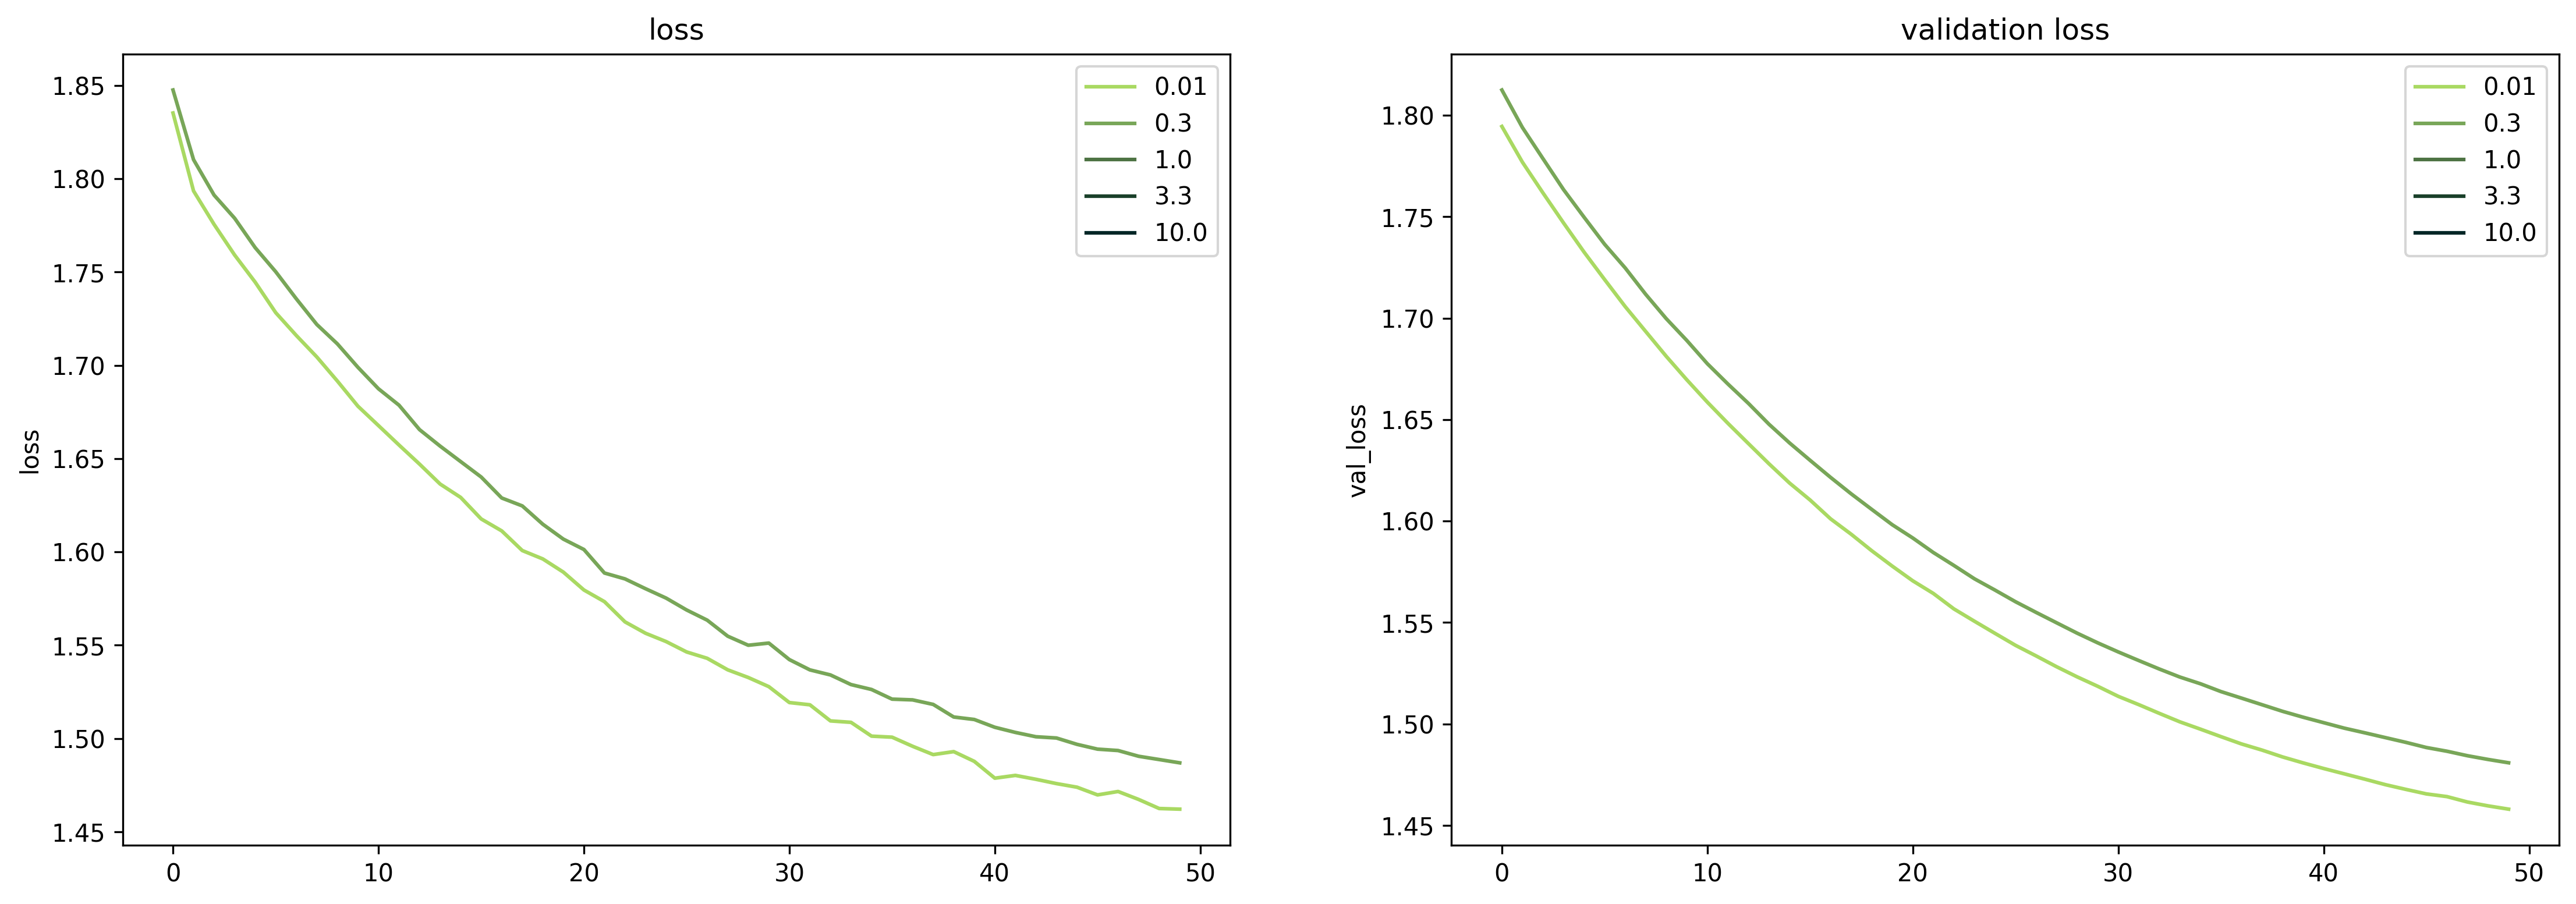

In [6]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
his_seq = [history_a1, history_a2, history_a3, history_a4, history_a5]
his_spr = [history_a1_in, history_a2_in, history_a3_in, history_a4_in, history_a5_in]
colors = ['#A9D962', '#78A658', '#4D7343', '#1A402A', '#012626']
alphas = [0.01, 0.3, 1.0, 3.3, 10.0]
delta = 0.1

for i in range(5):
    sns.lineplot(x=range(his_seq[i].shape[0]), y=np.log(his_seq[i].loss + delta * i), ax=axes[0], color=colors[i],
                 label=f'{alphas[i]}')
    sns.lineplot(x=range(his_seq[i].shape[0]), y=np.log(his_seq[i].val_loss + delta * i), ax=axes[1], color=colors[i],
                 label=f'{alphas[i]}')
    axes[0].set_title(f'loss')
    axes[1].set_title(f'validation loss')

plt.savefig('../../images/activation/experimental tests/exp__test_01_act_eval.jpg')
plt.show()

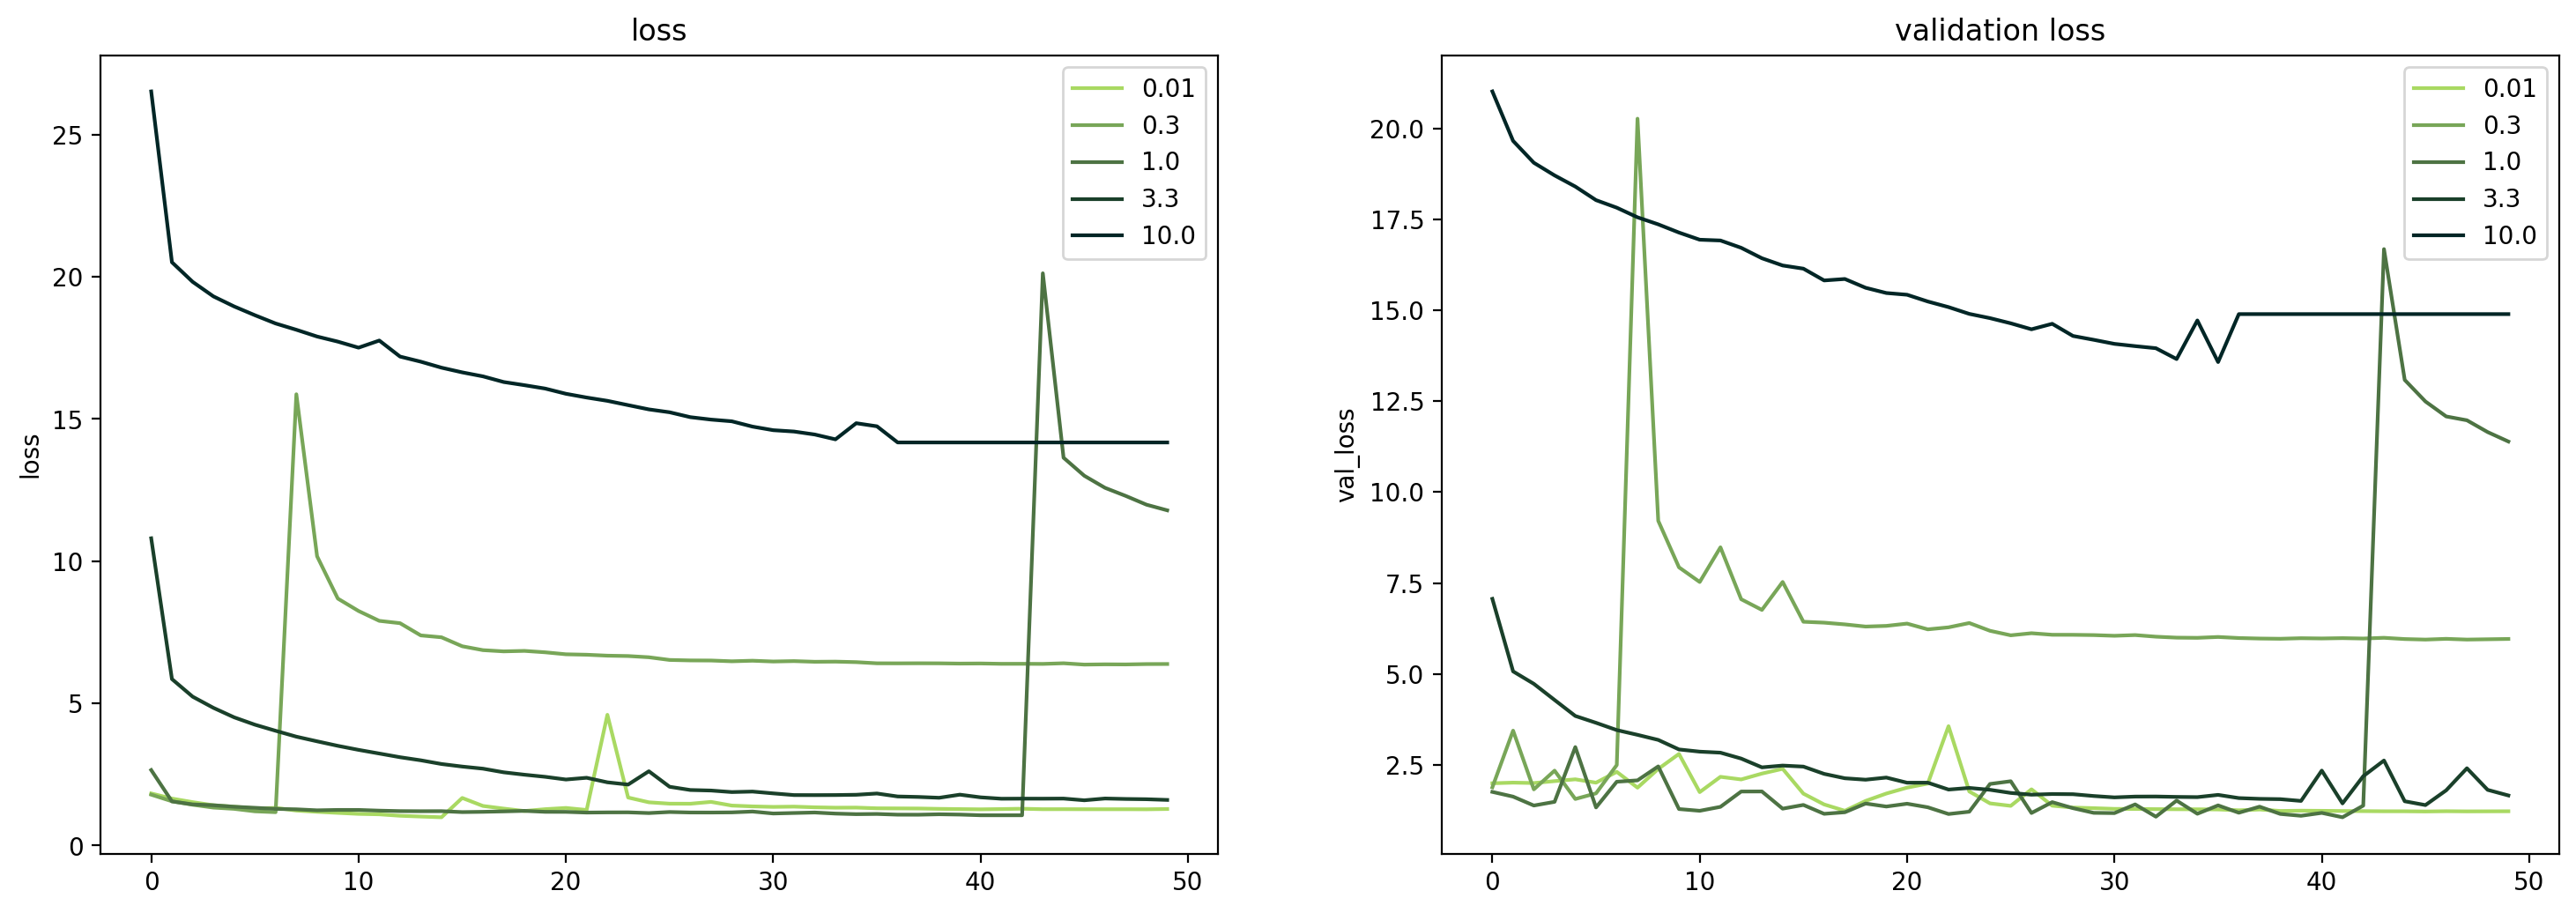

In [43]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=200)
colors = ['#A9D962', '#78A658', '#4D7343', '#1A402A', '#012626']
alphas = [0.01, 0.3, 1.0, 3.3, 10.0]
delta = 0.0

for i in range(5):
    sns.lineplot(x=range(his_spr[i].shape[0]), y=np.log(his_spr[i].loss + delta * i), ax=axes[0], color=colors[i],
                 label=f'{alphas[i]}')
    sns.lineplot(x=range(his_spr[i].shape[0]), y=np.log(his_spr[i].val_loss + delta * i), ax=axes[1], color=colors[i],
                 label=f'{alphas[i]}')
    axes[0].set_title(f'loss')
    axes[1].set_title(f'validation loss')

plt.savefig('../../images/activation/experimental tests/exp__test_01_act_eval-spr-mod.jpg')
plt.show()

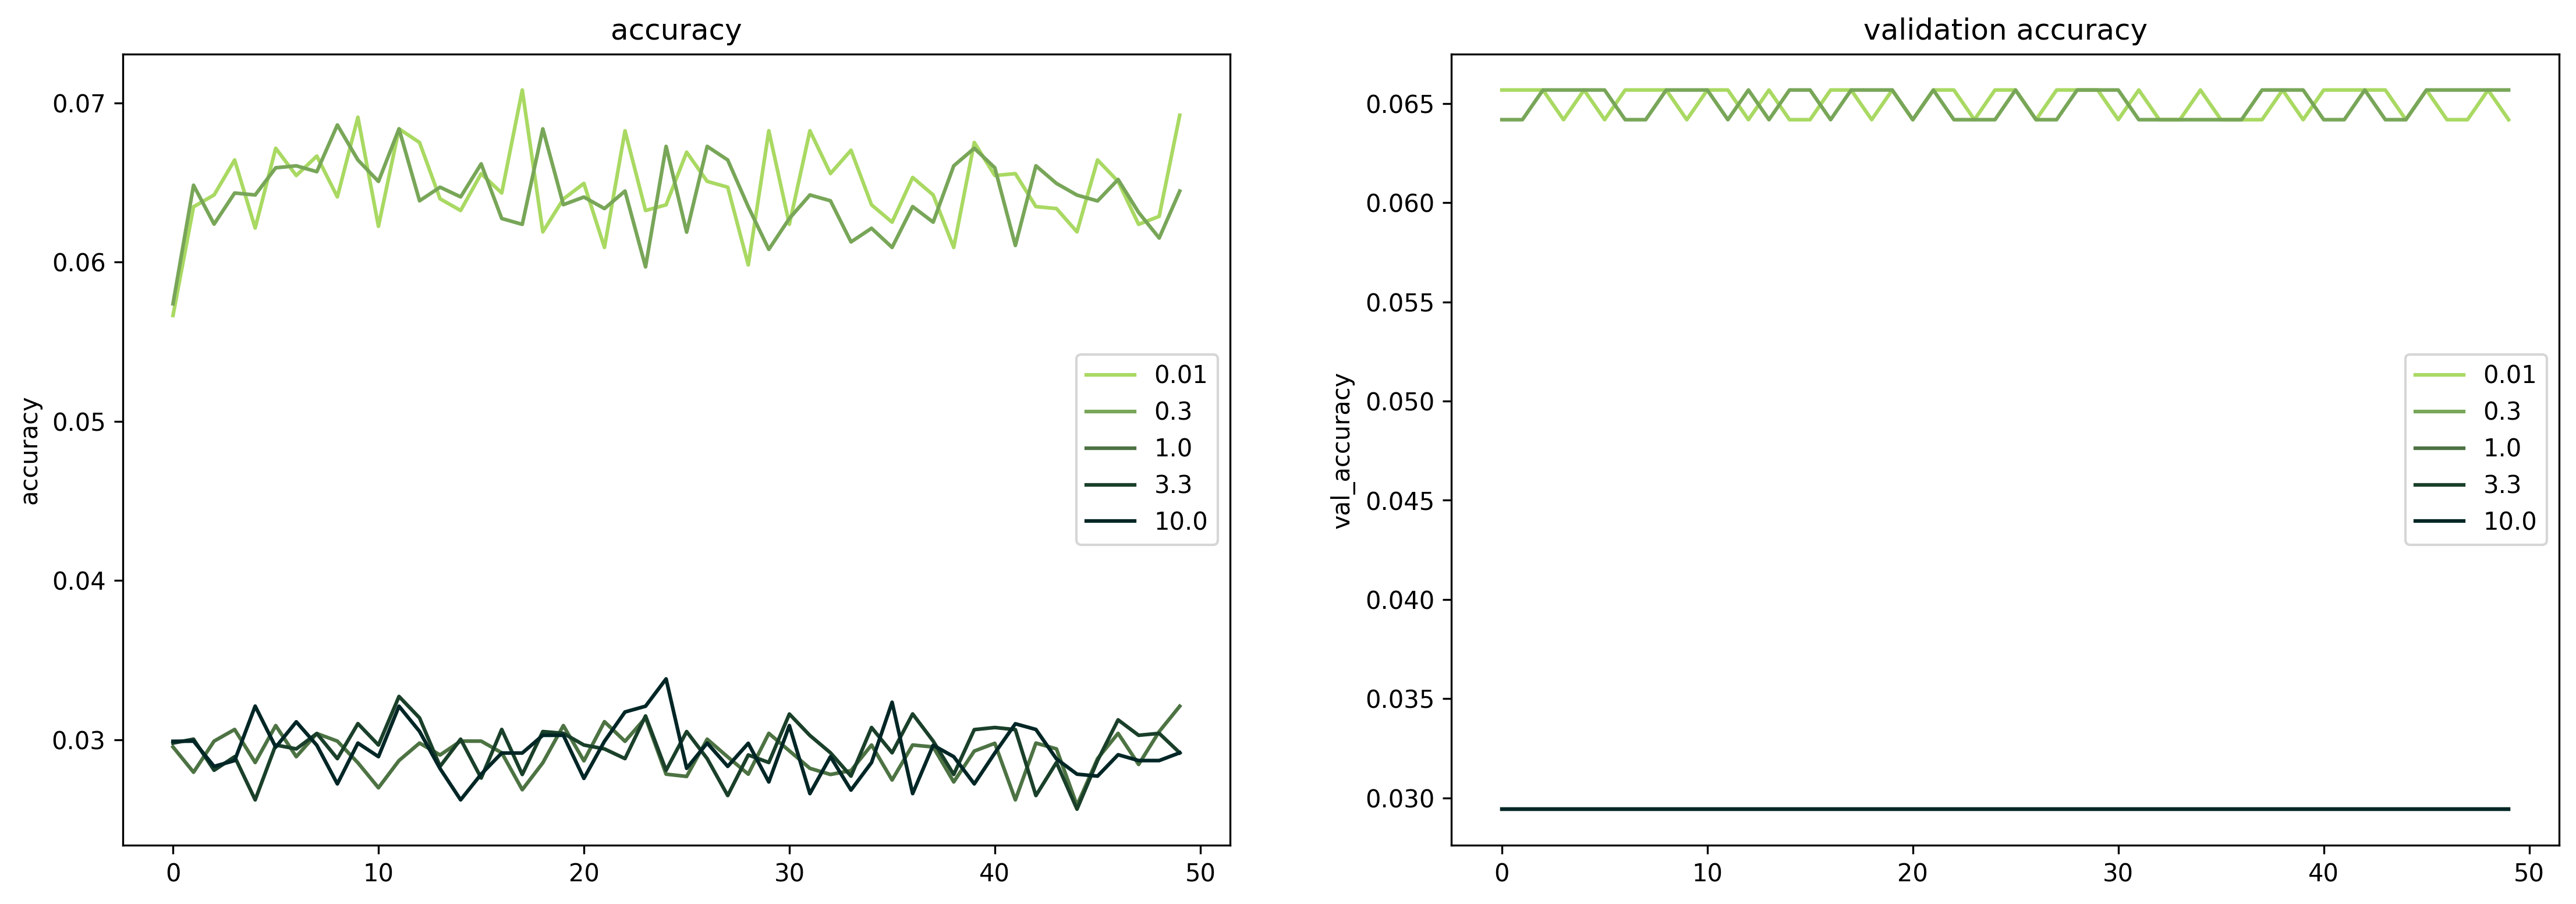

In [47]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
colors = ['#A9D962', '#78A658', '#4D7343', '#1A402A', '#012626']
alphas = [0.01, 0.3, 1.0, 3.3, 10.0]

for i in range(5):
    sns.lineplot(x=range(his_seq[i].shape[0]), y=his_seq[i].accuracy, ax=axes[0], color=colors[i],
                 label=f'{alphas[i]}')
    sns.lineplot(x=range(his_seq[i].shape[0]), y=his_seq[i].val_accuracy, ax=axes[1], color=colors[i],
                 label=f'{alphas[i]}')
    axes[0].set_title(f'accuracy')
    axes[1].set_title(f'validation accuracy')

plt.savefig('../../images/activation/experimental tests/exp__test_01_act_eval-seq-acc.jpg')
plt.show()

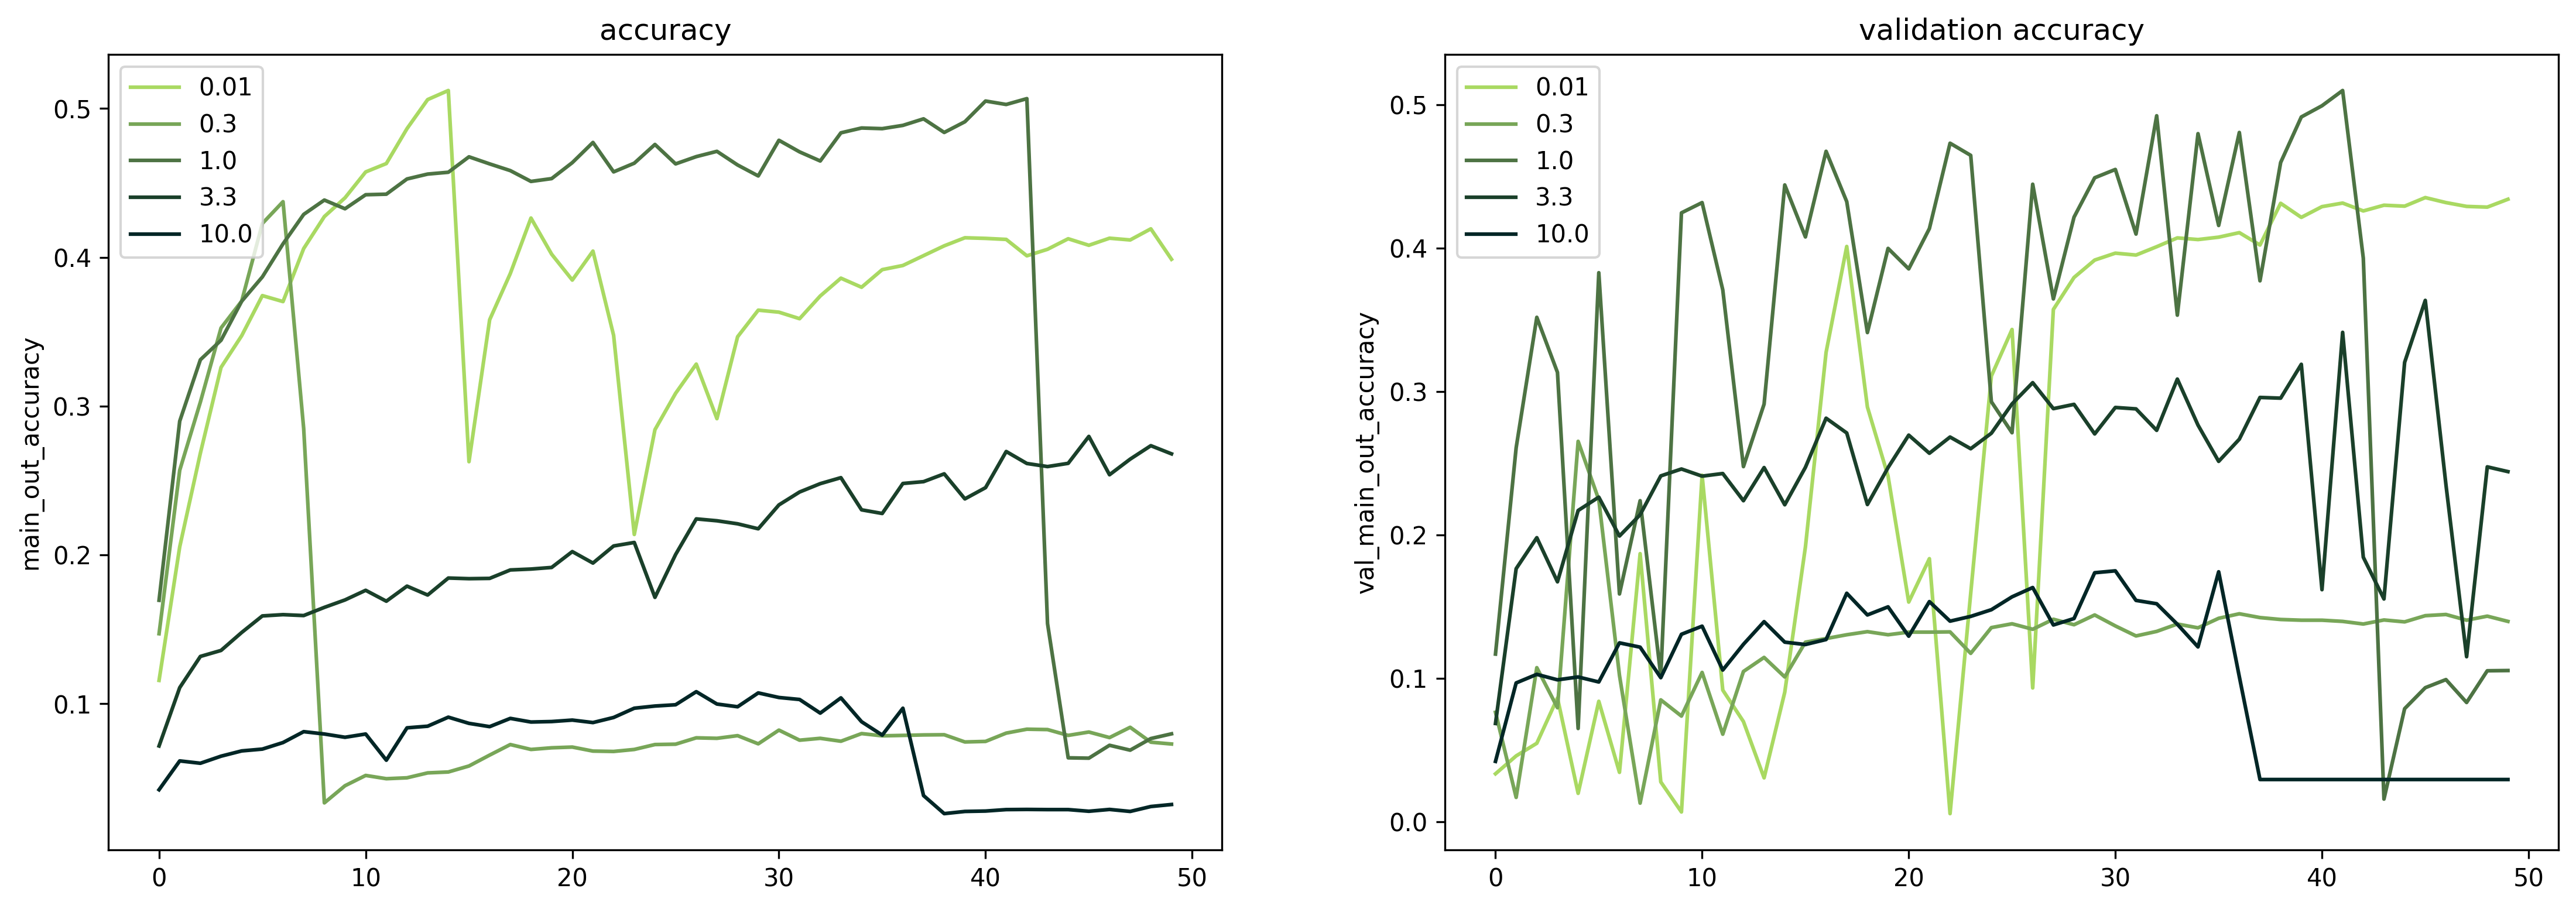

In [7]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
colors = ['#A9D962', '#78A658', '#4D7343', '#1A402A', '#012626']
alphas = [0.01, 0.3, 1.0, 3.3, 10.0]

for i in range(5):
    sns.lineplot(x=range(his_spr[i].shape[0]), y=his_spr[i].main_out_accuracy, ax=axes[0], color=colors[i],
                 label=f'{alphas[i]}')
    sns.lineplot(x=range(his_spr[i].shape[0]), y=his_spr[i].val_main_out_accuracy, ax=axes[1], color=colors[i],
                 label=f'{alphas[i]}')
    axes[0].set_title(f'accuracy')
    axes[1].set_title(f'validation accuracy')

plt.savefig('../../images/activation/experimental tests/exp__test_01_act_eval-spr-acc.jpg')
plt.show()

## Test 02

In [ ]:
# inception with prelu
def inception_with_prelu(x, filters, projection, classes=None, aux=False, name=None, aux_name=None):
    f_1x1, f_3x3, f_3x3_reduce, f_5x5, f_5x5_reduce = filters
    x1 = Conv2D(filters=f_1x1, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x1 = PReLU()(x1)
    x3_reducer = Conv2D(filters=f_3x3_reduce, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x3_reducer = PReLU()(x3_reducer)
    x5_reducer = Conv2D(filters=f_5x5_reduce, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x5_reducer = PReLU()(x5_reducer)
    pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    x3 = Conv2D(filters=f_3x3, kernel_size=(3, 3), strides=(1, 1), padding='same')(x3_reducer)
    x3 = PReLU()(x3)
    x5 = Conv2D(filters=f_5x5, kernel_size=(5, 5), strides=(1, 1), padding='same')(x5_reducer)
    x5 = PReLU()(x5)
    proj = Conv2D(filters=projection, kernel_size=(1, 1), strides=(1, 1), padding='same')(pool)
    proj = PReLU()(proj)

    x = concatenate([x1, x3, x5, proj], axis=3, name=name)

    return x


def model_builder_with_prelu(shape, classes):
    input_layer = Input(shape=shape)
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_layer)
    x = PReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = PReLU()(x)
    x = Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_with_prelu(x, [64, 128, 96, 32, 16], projection=32, name='inception_3a')
    x = inception_with_prelu(x, [128, 192, 128, 96, 32], projection=64, name='inception_3b')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_with_prelu(x, [192, 208, 96, 48, 16], projection=64, name='inception_4a')

    aux_1 = AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='valid')(x)
    aux_1 = Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='valid')(aux_1)
    aux_1 = PReLU()(aux_1)
    aux_1 = Dense(units=1024)(aux_1)
    aux_1 = PReLU()(aux_1)
    aux_1 = Dropout(rate=0.7)(aux_1)
    aux_1 = Flatten()(aux_1)
    aux_out1 = Dense(units=classes, activation='softmax', name='aux_out1')(aux_1)

    x = inception_with_prelu(x, [160, 224, 112, 64, 24], projection=64, name='inception_4b')
    x = inception_with_prelu(x, [128, 256, 128, 64, 24], projection=64, name='inception_4c')
    x = inception_with_prelu(x, [112, 288, 144, 64, 32], projection=64, name='inception_4d')
    x = inception_with_prelu(x, [256, 320, 160, 128, 32], projection=128, name='inception_4e')

    aux_2 = AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='valid')(x)
    aux_2 = Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='valid')(aux_2)
    aux_2 = PReLU()(aux_2)
    aux_2 = Dense(units=1024)(aux_2)
    aux_2 = PReLU()(aux_2)
    aux_2 = Dropout(rate=0.7)(aux_2)
    aux_2 = Flatten()(aux_2)
    aux_out2 = Dense(units=classes, activation='softmax', name='aux_out2')(aux_2)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_with_prelu(x, [256, 320, 160, 128, 32], projection=128, name='inception_5a')
    x = inception_with_prelu(x, [384, 384, 192, 128, 48], projection=128, name='inception_5b')
    x = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(x)
    x = Dropout(rate=0.4)(x)
    x = Flatten()(x)
    output_layer = Dense(units=classes, activation='softmax', name='main_out')(x)

    model = Model(input_layer, [output_layer, aux_out1, aux_out2])
    model.compile(optimizer=Adam(), loss=categorical_crossentropy,
                  loss_weights={'main_out': 1, 'aux_out1': 0.3, 'aux_out2': 0.3},
                  metrics=['accuracy'])
    # model.summary()

    return model

In [ ]:
# inception with leaky rrelu
def inception_with_rrelu(x, filters, projection, classes=None, aux=False, name=None, aux_name=None):
    f_1x1, f_3x3, f_3x3_reduce, f_5x5, f_5x5_reduce = filters
    x1 = Conv2D(filters=f_1x1, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x1 = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(x1)
    x3_reducer = Conv2D(filters=f_3x3_reduce, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x3_reducer = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(x3_reducer)
    x5_reducer = Conv2D(filters=f_5x5_reduce, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x5_reducer = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(x5_reducer)
    pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    x3 = Conv2D(filters=f_3x3, kernel_size=(3, 3), strides=(1, 1), padding='same')(x3_reducer)
    x3 = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(x3)
    x5 = Conv2D(filters=f_5x5, kernel_size=(5, 5), strides=(1, 1), padding='same')(x5_reducer)
    x5 = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(x5)
    proj = Conv2D(filters=projection, kernel_size=(1, 1), strides=(1, 1), padding='same')(pool)
    proj = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(proj)

    x = concatenate([x1, x3, x5, proj], axis=3, name=name)

    return x


def model_builder_with_rrelu(shape, classes):
    input_layer = Input(shape=shape)
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_layer)
    x = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(x)
    x = Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_with_rrelu(x, [64, 128, 96, 32, 16], projection=32, name='inception_3a')
    x = inception_with_rrelu(x, [128, 192, 128, 96, 32], projection=64, name='inception_3b')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_with_rrelu(x, [192, 208, 96, 48, 16], projection=64, name='inception_4a')

    aux_1 = AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='valid')(x)
    aux_1 = Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='valid')(aux_1)
    aux_1 = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(aux_1)
    aux_1 = Dense(units=1024)(aux_1)
    aux_1 = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(aux_1)
    aux_1 = Dropout(rate=0.7)(aux_1)
    aux_1 = Flatten()(aux_1)
    aux_out1 = Dense(units=classes, activation='softmax', name='aux_out1')(aux_1)

    x = inception_with_rrelu(x, [160, 224, 112, 64, 24], projection=64, name='inception_4b')
    x = inception_with_rrelu(x, [128, 256, 128, 64, 24], projection=64, name='inception_4c')
    x = inception_with_rrelu(x, [112, 288, 144, 64, 32], projection=64, name='inception_4d')
    x = inception_with_rrelu(x, [256, 320, 160, 128, 32], projection=128, name='inception_4e')

    aux_2 = AveragePooling2D(pool_size=(5, 5), strides=(3, 3), padding='valid')(x)
    aux_2 = Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='valid')(aux_2)
    aux_2 = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(aux_2)
    aux_2 = Dense(units=1024)(aux_2)
    aux_2 = Lambda(lambda x_: tfa.activations.rrelu(x_, 3, 8, training=True))(aux_2)
    aux_2 = Dropout(rate=0.7)(aux_2)
    aux_2 = Flatten()(aux_2)
    aux_out2 = Dense(units=classes, activation='softmax', name='aux_out2')(aux_2)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_with_rrelu(x, [256, 320, 160, 128, 32], projection=128, name='inception_5a')
    x = inception_with_rrelu(x, [384, 384, 192, 128, 48], projection=128, name='inception_5b')
    x = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(x)
    x = Dropout(rate=0.4)(x)
    x = Flatten()(x)
    output_layer = Dense(units=classes, activation='softmax', name='main_out')(x)

    model = Model(input_layer, [output_layer, aux_out1, aux_out2])
    model.compile(optimizer=Adam(), loss=categorical_crossentropy,
                  loss_weights={'main_out': 1, 'aux_out1': 0.3, 'aux_out2': 0.3},
                  metrics=['accuracy'])
    # model.summary()

    return model

In [ ]:
inception_lr = model_builder(shape=(96, 96, 3), classes=121, alpha=1.0)
inception_pr = model_builder_with_prelu(shape=(96, 96, 3), classes=121)
inception_rr = model_builder_with_rrelu(shape=(96, 96, 3), classes=121)

In [ ]:
history_lr_in = inception_lr.fit(train_batch,
                                 epochs=50,
                                 validation_data=valid_batch,
                                 steps_per_epoch=256,
                                 callbacks=[reduce_lr])

pd.DataFrame(history_lr_in.history).to_pickle('history_lr_in.pkl')

In [ ]:
history_pr_in = inception_pr.fit(train_batch,
                                 epochs=50,
                                 validation_data=valid_batch,
                                 steps_per_epoch=256,
                                 callbacks=[reduce_lr])

pd.DataFrame(history_pr_in.history).to_pickle('history_pr_in.pkl')

In [ ]:
history_rr_in = inception_rr.fit(train_batch,
                                 epochs=50,
                                 validation_data=valid_batch,
                                 steps_per_epoch=256,
                                 callbacks=[reduce_lr])

pd.DataFrame(history_rr_in.history).to_pickle('history_rr_in.pkl')

## Evaluation

In [2]:
history_lr_in=pd.read_pickle('experiment act/history_lr_in.pkl').fillna(method='ffill')
history_pr_in=pd.read_pickle('experiment act/history_pr_in.pkl').fillna(method='ffill')
history_rr_in=pd.read_pickle('experiment act/history_rr_in.pkl').fillna(method='ffill')

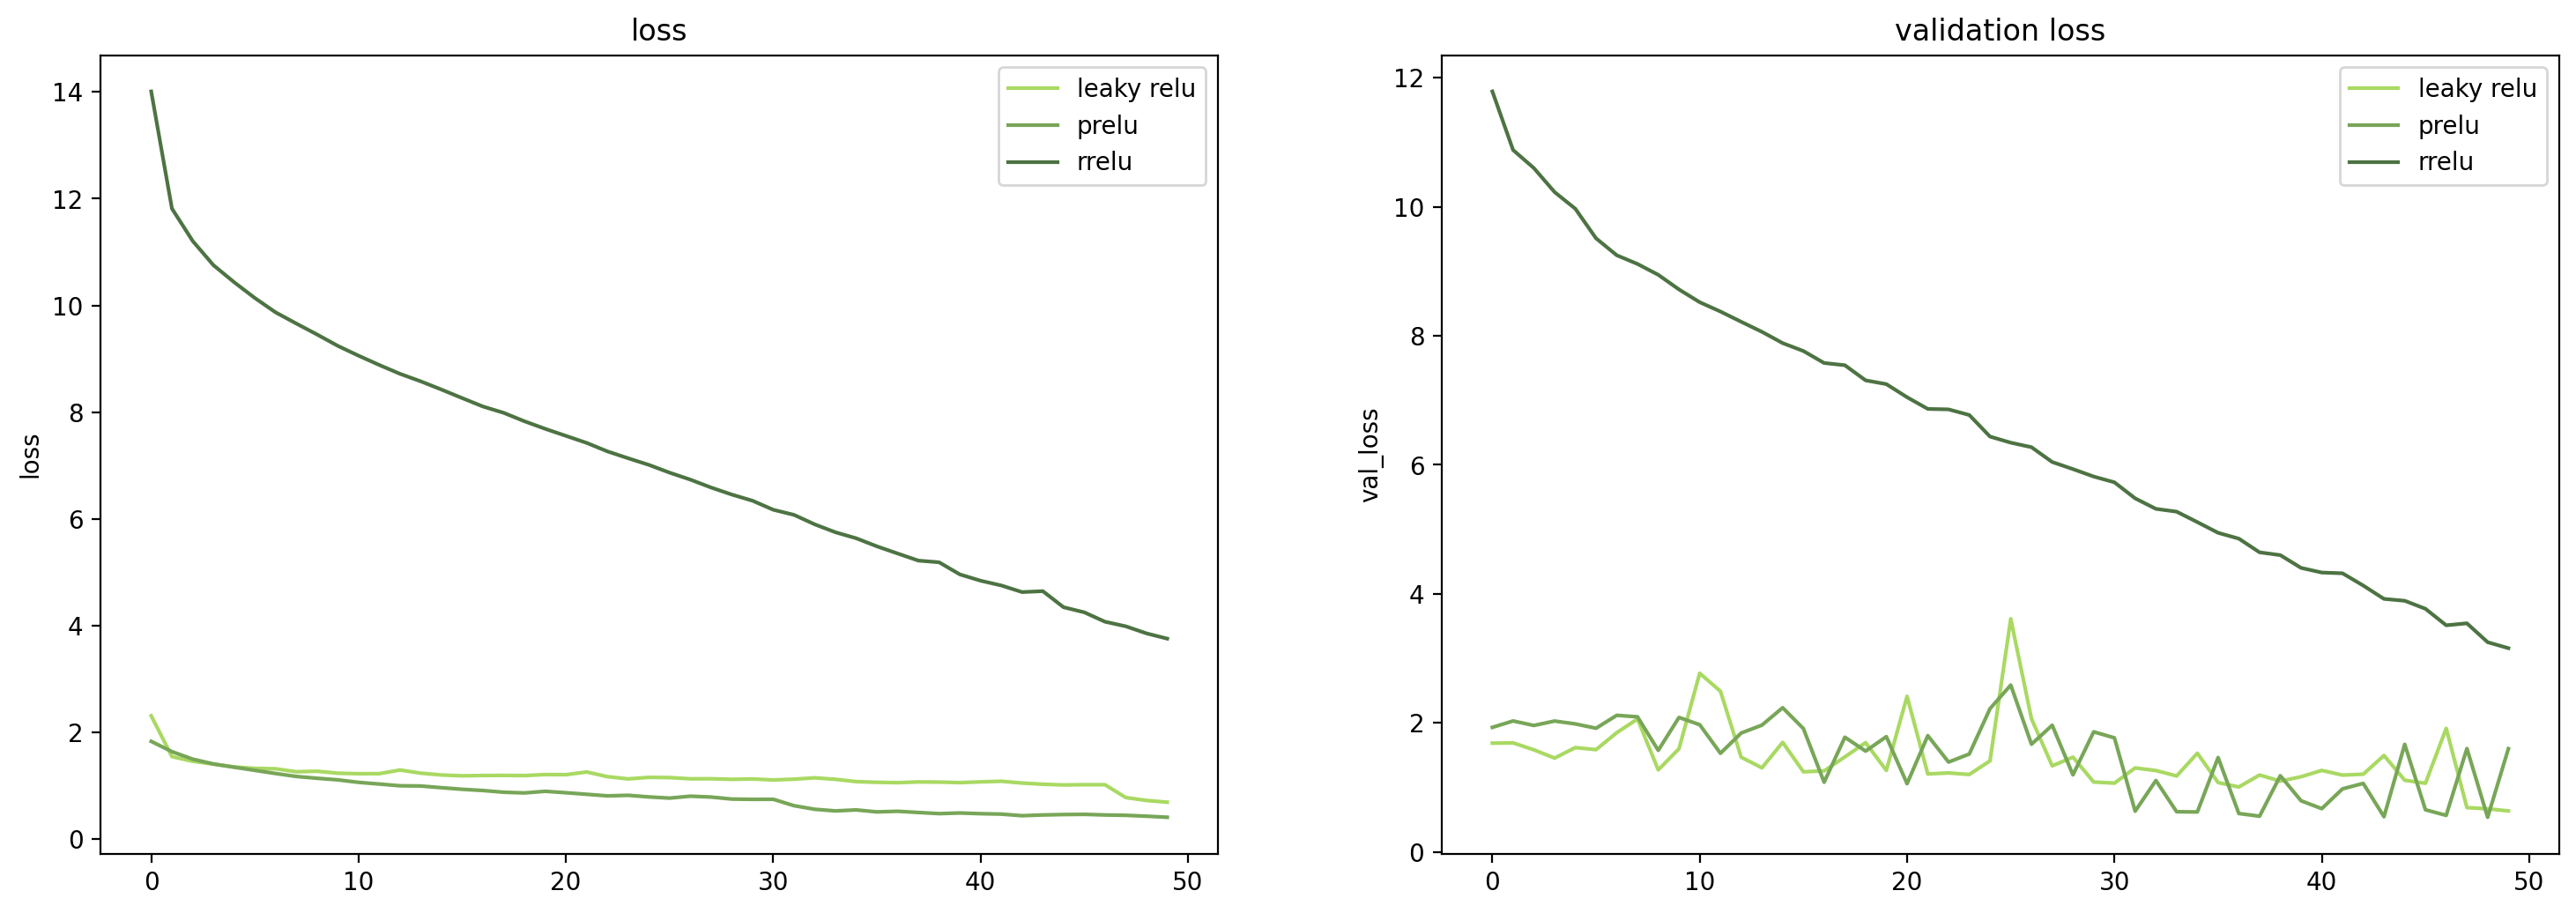

In [8]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=200)
his_test_2 = [history_lr_in, history_pr_in, history_rr_in]
act = ['leaky relu','prelu','rrelu']
delta = 0.0

for i in range(3):
    sns.lineplot(x=range(his_test_2[i].shape[0]), y=np.log(his_test_2[i].loss + delta * i), ax=axes[0], color=colors[i],
                 label=f'{act[i]}')
    sns.lineplot(x=range(his_test_2[i].shape[0]), y=np.log(his_test_2[i].val_loss + delta * i), ax=axes[1], color=colors[i],
                 label=f'{act[i]}')
    axes[0].set_title(f'loss')
    axes[1].set_title(f'validation loss')

plt.savefig('../../images/activation/experimental tests/exp__test_02_act_eval-spr-mod.jpg')
plt.show()

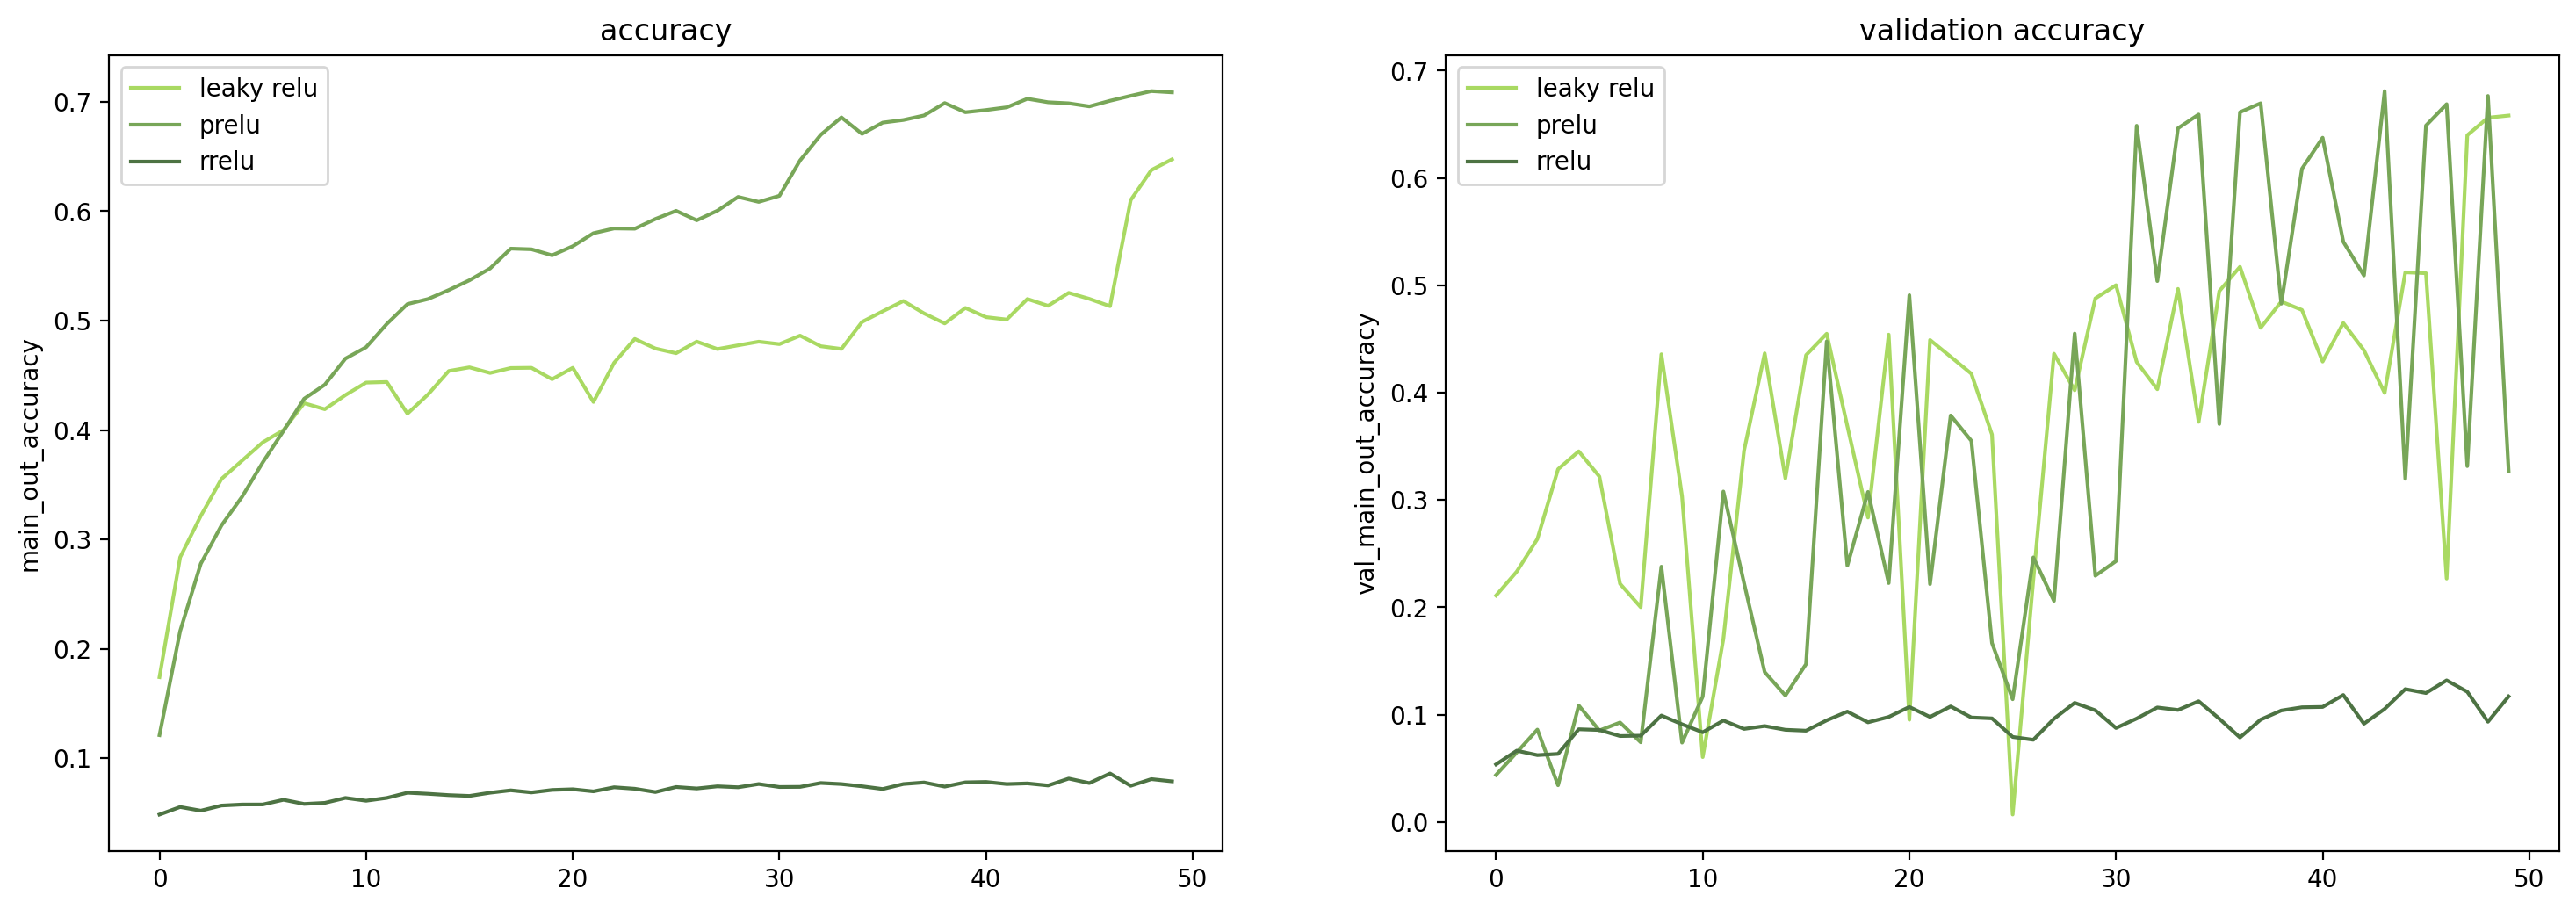

In [10]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=200)
delta = 0.0

for i in range(3):
    sns.lineplot(x=range(his_test_2[i].shape[0]), y=his_test_2[i].main_out_accuracy, ax=axes[0], color=colors[i],
                 label=f'{act[i]}')
    sns.lineplot(x=range(his_test_2[i].shape[0]), y=his_test_2[i].val_main_out_accuracy, ax=axes[1], color=colors[i],
                 label=f'{act[i]}')
    axes[0].set_title(f'accuracy')
    axes[1].set_title(f'validation accuracy')

plt.savefig('../../images/activation/experimental tests/exp__test_02_act_eval-spr-mod-acc.jpg')
plt.show()